# Basic experiment

# Make toy data

## Type 1. Independent Gaussian

$$
(x_1, x_2) \sim \mathcal{N}(0,I)
$$

## Type 2. Correlated Gaussian

$$
(y_1, y_2) \sim \mathcal{N}(0,\begin{bmatrix}1&\rho\\ \rho&1\end{bmatrix})
$$

In [1]:
import numpy as np

In [2]:
x = np.random.multivariate_normal( mean=[0,0],
                                  cov=[[1,0],[0,1]],
                                 size = 300)

In [3]:
y = np.random.multivariate_normal( mean=[0,0],
                                  cov=[[1,0.8],[0.8,1]],
                                 size = 300)

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

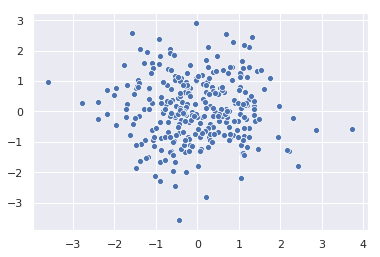

In [5]:
# plt indep Gaussian
sns.scatterplot(x=x[:,0],y=x[:,1])

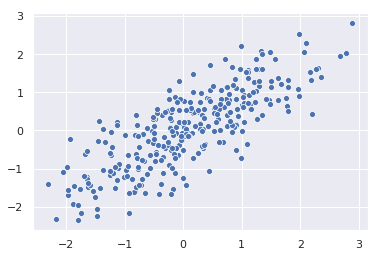

In [6]:
# plt cor Gaussian
sns.scatterplot(x=y[:,0],y=y[:,1])

# Define MINE

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd

In [8]:
class Mine(nn.Module):
    def __init__(self, input_size=2, hidden_size=100):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        nn.init.normal_(self.fc1.weight,std=0.02)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.normal_(self.fc2.weight,std=0.02)
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.normal_(self.fc3.weight,std=0.02)
        nn.init.constant_(self.fc3.bias, 0)
        
    def forward(self, input):
        output = F.elu(self.fc1(input))
        output = F.elu(self.fc2(output))
        output = self.fc3(output)
        return output

In [9]:
def mutual_information(joint, marginal, mine_net):
    t = mine_net(joint)
    et = torch.exp(mine_net(marginal))
    mi_lb = torch.mean(t) - torch.log(torch.mean(et))
    return mi_lb, t, et

def learn_mine(batch, mine_net, mine_net_optim,  ma_et, ma_rate=0.1):
    # batch is a tuple of (joint, marginal)
    joint , marginal = batch
    joint = torch.autograd.Variable(torch.FloatTensor(joint)).cuda()
    marginal = torch.autograd.Variable(torch.FloatTensor(marginal)).cuda()
    mi_lb , t, et = mutual_information(joint, marginal, mine_net)
    ma_et = (1-ma_rate)*ma_et + ma_rate*torch.mean(et)
    
    loss = -(torch.mean(t) - (et.mean()/ma_et.mean()).detach()*torch.log(torch.mean(et)))
    
    mine_net_optim.zero_grad()
    autograd.backward(loss)
    mine_net_optim.step()
    return mi_lb, ma_et

In [10]:
def sample_batch(data, batch_size=100, sample_mode='joint'):
    if sample_mode == 'joint':
        index = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
        batch = data[index]
    else:
        joint_index = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
        marginal_index = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
        batch = np.concatenate([data[joint_index][:,0].reshape(-1,1),
                                         data[marginal_index][:,1].reshape(-1,1)],
                                       axis=1)
    return batch

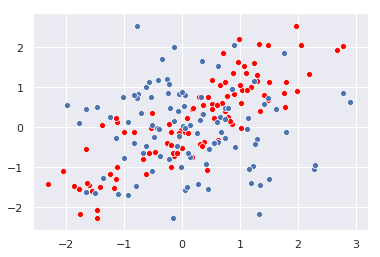

In [11]:
joint_data = sample_batch(y,batch_size=100,sample_mode='joint')
sns.scatterplot(x=joint_data[:,0],y=joint_data[:,1],color='red')
marginal_data = sample_batch(y,batch_size=100,sample_mode='marginal')
sns.scatterplot(x=marginal_data[:,0],y=marginal_data[:,1])

In [12]:
def train(data, mine_net,mine_net_optim, batch_size=100, iter_num=int(5e+3), log_freq=1e+3):
    # data is x or y
    result = list()
    ma_et = 1.
    for i in range(iter_num):
        batch = sample_batch(data,batch_size=batch_size)\
        , sample_batch(data,batch_size=batch_size,sample_mode='marginal')
        mi_lb, ma_et = learn_mine(batch, mine_net, mine_net_optim, ma_et)
        result.append(mi_lb.detach().cpu().numpy())
        if (i+1)%(log_freq)==0:
            print(result[-1])
    return result

In [13]:
def ma(a, window_size=100):
    return [np.mean(a[i:i+window_size]) for i in range(0,len(a)-window_size)]

In [14]:
mine_net_indep = Mine().cuda()
mine_net_optim_indep = optim.Adam(mine_net_indep.parameters(), lr=1e-4)
result_indep = train(x,mine_net_indep,mine_net_optim_indep)

-0.0003373234
-0.0005798002
0.00029213208
-7.654715e-06
-6.586098e-05


-2.0858024e-05


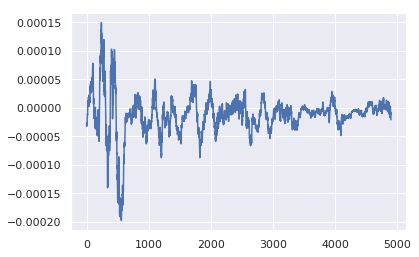

In [15]:
result_indep_ma = ma(result_indep)
print(result_indep_ma[-1])
plt.plot(range(len(result_indep_ma)),result_indep_ma)

In [16]:
mine_net_cor = Mine().cuda()
mine_net_optim_cor = optim.Adam(mine_net_cor.parameters(), lr=1e-4)
result_cor = train(y,mine_net_cor,mine_net_optim_cor)

0.0048206933
0.47408545
0.47356153
0.70922107
0.3624663


0.5008186


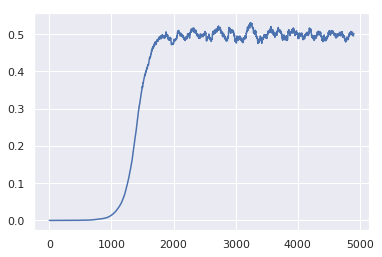

In [17]:
result_cor_ma = ma(result_cor)
print(result_cor_ma[-1])
plt.plot(range(len(result_cor_ma)),result_cor_ma)

# Test with various correlations

In [18]:
correlations = np.linspace(-0.9,0.9,19)
print(correlations)

[-0.9 -0.8 -0.7 -0.6 -0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4
  0.5  0.6  0.7  0.8  0.9]


0.025445215
0.3198852
0.78272784
0.7062925
1.006793
-0.9 : 0.81552243
0.009670634
0.6809764
0.7392397
0.5268871
0.3743063
-0.8 : 0.55177754
0.0027349181
0.3251078
0.38037145
0.3187755
0.3924879
-0.7 : 0.35009846
0.0002507642
0.15479182
0.18321067
0.2992733
0.20544752
-0.6 : 0.21887194
0.0013401626
0.021020025
0.1045009
0.17929837
0.20270285
-0.5 : 0.14192672
4.0558865e-05
0.0012549832
0.056755677
0.16133364
0.062001076
-0.4 : 0.10264151
-0.00029419677
0.00094088656
0.002919124
0.013175406
0.041120745
-0.29999999999999993 : 0.043215856
0.0001347778
-0.000246434
-0.00021482207
0.00027910605
0.0021164524
-0.19999999999999996 : 6.70519e-05
-0.0007867693
-0.0002548379
-9.494573e-05
-0.00019058806
0.00010071926
-0.09999999999999998 : -3.6508525e-05
-9.4698335e-06
0.00022068777
6.5033964e-05
0.00014856117
0.00030364154
0.0 : -3.4997607e-05
-0.000369147
-0.0006649232
5.5334764e-05
0.0026489547
0.0017380705
0.09999999999999998 : 0.00028337858
-0.0015083326
-0.00048733206
7.2747906e-05
0.0006162

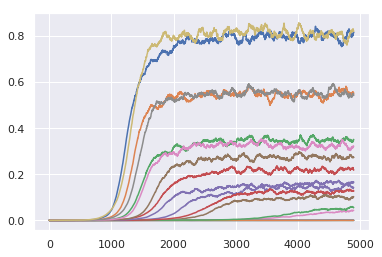

In [19]:
final_result = []
for rho in correlations:
    rho_data = np.random.multivariate_normal( mean=[0,0],
                                  cov=[[1,rho],[rho,1]],
                                 size = 300)
    mine_net = Mine().cuda()
    mine_net_optim = optim.Adam(mine_net.parameters(), lr=1e-4)
    result = train(rho_data,mine_net,mine_net_optim)
    result_ma = ma(result)
    final_result.append(result_ma[-1])
    print(str(rho) + ' : ' + str(final_result[-1]))
    plt.plot(range(len(result_ma)),result_ma)

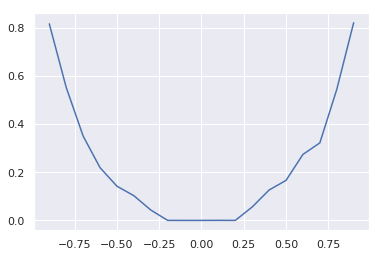

In [20]:
plt.plot(correlations, final_result)

# Equitability experiment

Check more information at [original equitability paper](http://www.pnas.org/content/pnas/111/9/3354.full.pdf).

# Make toy data

In [21]:
x = np.random.uniform(low=-1.,high=1.,size=3000)
f1 = x
f2 = 2*x
f3 = np.sin(x)
f4 = x**3
eps = np.random.normal(size=3000)

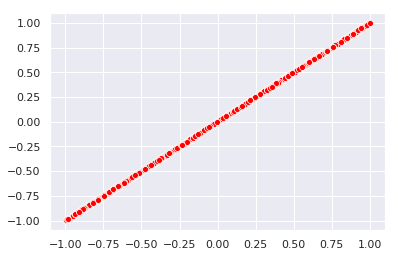

In [22]:
sns.scatterplot(x, f1,color='red')

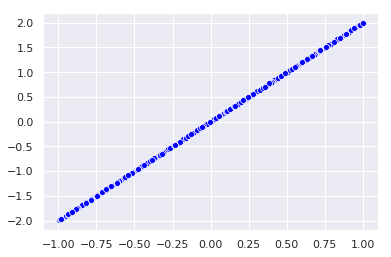

In [23]:
sns.scatterplot(x, f2,color='blue')

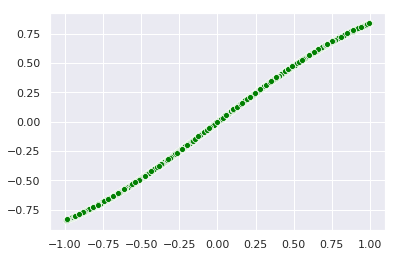

In [24]:
sns.scatterplot(x, f3,color='green')

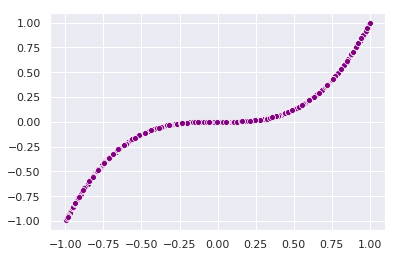

In [25]:
sns.scatterplot(x, f4,color='purple')

In [26]:
sigmas = np.linspace(0.0,0.9,10)
fs = [f1, f2, f3, f4]
print(sigmas)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


7.519976e-05
0.14020717
1.7999089
2.4102385
2.797513
0.0,0 : 2.7752643
0.006078949
1.701093
2.166689
3.1469483
2.8557925
0.0,1 : 2.9880831
0.0026241005
0.14961047
1.5351901
2.5028324
2.940257
0.0,2 : 2.441453
0.0003146567
0.004556548
0.74006164
0.7863477
0.98293155
0.0,3 : 1.0011979
0.001267655
0.19965567
1.5506588
1.5705874
1.4674098
0.1,0 : 1.7089009
-0.0031631403
1.1348193
1.7559366
2.0955362
1.8757443
0.1,1 : 2.22988
0.0013097178
0.03385463
0.9034723
1.3808078
1.4724523
0.1,2 : 1.4755716
-0.0010613964
-0.0013974132
0.5811479
0.75705516
0.71635306
0.1,3 : 0.7553186
0.0012660058
0.040114533
0.8270452
0.8212521
1.2451398
0.2,0 : 1.0604444
0.005125423
1.2287025
1.576491
1.2553148
1.4743145
0.2,1 : 1.6415915
-0.00068708323
0.3923326
0.7295457
0.9729258
1.2977208
0.2,2 : 0.96265364
7.489376e-06
0.0023795168
0.4146065
0.5972423
0.58357
0.2,3 : 0.52050453
0.0010824166
0.063247286
0.5462997
0.7730365
0.7037233
0.30000000000000004,0 : 0.7145429
0.009223549
1.1017361
1.2487149
1.3885374
1.129

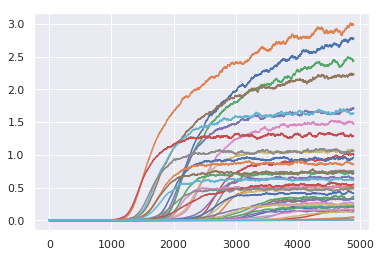

In [27]:
final_result = []
for sigma in sigmas:
    for fi, f in enumerate(fs):
        data = np.concatenate([x.reshape(-1,1), (f + sigma * eps).reshape(-1,1)], axis=1)
        mine_net = Mine().cuda()
        mine_net_optim = optim.Adam(mine_net.parameters(), lr=1e-4)
        result = train(data,mine_net,mine_net_optim,batch_size=100,iter_num=int(5e+3))
        result_ma = ma(result)
        final_result.append(result_ma[-1])
        print(str(sigma) + ',' + str(fi) +' : ' + str(final_result[-1]))
        plt.plot(range(len(result_ma)),result_ma)

In [28]:
re_final_result = np.transpose(np.array([final_result[4*i: 4*i+4]  for i in range(10)]))
print(re_final_result)

[[2.7752643  1.7089009  1.0604444  0.7145429  0.50160944 0.41267297
  0.3240129  0.2381406  0.19002783 0.15734366]
 [2.9880831  2.22988    1.6415915  1.2873197  1.0550207  0.84927446
  0.7256277  0.6102172  0.5511551  0.48646963]
 [2.441453   1.4755716  0.96265364 0.63906026 0.47727242 0.36710083
  0.2584639  0.21023765 0.14223026 0.12224085]
 [1.0011979  0.7553186  0.52050453 0.33539018 0.23604208 0.16259587
  0.04096325 0.05394554 0.0073551  0.00699298]]


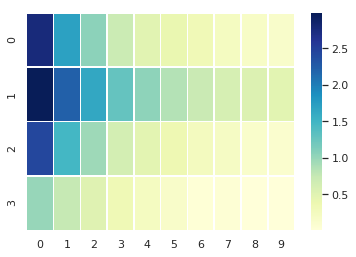

In [29]:
sns.heatmap(re_final_result,cmap="YlGnBu",linewidths=.5)